In [1]:
# Install necessary libraries
!pip install beautifulsoup4 py2neo



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install cssutils


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import json
import pandas as pd
from bs4 import BeautifulSoup
import cssutils  # More robust CSS parser
import os

# File path to your JSONL file
file_path = "/Users/bhavikpatel/Desktop/RAG/training_data_gemini.json"

# Check if the file exists
if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
    exit()

# Load JSONL data
data = []
with open(file_path, "r") as f:
    for line in f:
        try:
            data.append(json.loads(line))
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
print(f"Loaded {len(data)} entries from the JSONL file.")

Loaded 256 entries from the JSONL file.


In [4]:
# Output directory for generated CSVs
output_path = "/Users/bhavikpatel/Desktop/RAG/RAG_Data/"
os.makedirs(output_path, exist_ok=True)

HTML logic

In [5]:
# Function to generate section context based on instructions
def generate_section_context(instruction):
    if "button" in instruction.lower():
        return "Styling for call-to-action button section."
    elif "navbar" in instruction.lower() or "navigation" in instruction.lower():
        return "Navigation bar for site links and user interaction."
    elif "header" in instruction.lower():
        return "Header section for introducing the website purpose."
    elif "hero" in instruction.lower():
        return "Hero section for showcasing key content or promotions."
    elif "card" in instruction.lower():
        return "Card layout for organizing related information visually."
    else:
        return "General section for webpage design."

def parse_html_with_context(html_content, section_context, instruction_id):
    soup = BeautifulSoup(html_content, "html.parser")
    html_components = []
    for tag in soup.find_all(True):
        # Skip redundant tags without meaningful attributes
        if tag.name in ["html", "head", "style", "body", "title", "span"] and not tag.attrs:
            continue

        # Generate context and description
        component_context, description = generate_html_context_and_description(tag.name, tag.attrs, section_context)

        # Append the component only if it adds meaningful information
        html_components.append({
            "instruction_id": instruction_id,  # Map to instruction_id
            "name": tag.name,
            "attributes": str(tag.attrs),
            "section_context": section_context,
            "component_context": component_context,
            "description": description
        })
    return html_components

# Function to generate context and description for HTML components
def generate_html_context_and_description(tag_name, attributes, section_context):
    class_name = attributes.get("class", [""])[0] if "class" in attributes else ""
    if tag_name == "div":
        if "header" in class_name:
            return "Container for header layout.", "Div element for grouping header content."
        elif "nav" in class_name:
            return "Container for navigation menus.", "Div element for grouping navigation items."
        elif "btn" in class_name or "button" in class_name:
            return "Container for buttons.", "Div element for grouping call-to-action buttons."
        else:
            return "Generic container for layout.", f"Generic div container for {class_name}."
    elif tag_name == "button":
        return "Interactive button for user interaction.", "Button element styled for clarity and user action."
    elif tag_name == "img":
        return "Image element for visual content.", f"Image element with attributes {attributes}."
    else:
        return f"HTML {tag_name} element.", f"General purpose {tag_name} element."


CSS logic

In [6]:
# Function to parse CSS and generate contexts using cssutils
def parse_css_with_context(css_code, section_context, instruction_id):
    css_parser = cssutils.CSSParser(validate=False)  # Disable strict validation
    cssutils.log.setLevel("FATAL")  # Suppress warnings
    css_styles = []
    try:
        stylesheet = css_parser.parseString(css_code)
        for rule in stylesheet:
            if rule.type == rule.STYLE_RULE:
                selector = rule.selectorText
                properties_dict = {prop.name: prop.value for prop in rule.style}  # Store properties as a dictionary
                properties_str = "; ".join([f"{key}: {value}" for key, value in properties_dict.items()])
                sub_context, description = generate_css_context_and_description(selector, properties_str, section_context)
                css_styles.append({
                    "instruction_id": instruction_id,  # Map to the instruction_id
                    "selector": selector,
                    "properties": properties_str,  # Flat properties
                    "properties_json": json.dumps(properties_dict),  # Hierarchical representation
                    "section_context": section_context,
                    "sub_context": sub_context,
                    "description": description
                })
    except Exception as e:
        print(f"Error parsing CSS: {e}")
    return css_styles


# Function to generate sub-context and description for CSS
def generate_css_context_and_description(css_class, css_properties, section_context):
    if "btn" in css_class or "button" in css_class:
        return "Styling for call-to-action buttons.", "Button with prominent color and rounded edges for user interaction."
    elif "header" in css_class:
        return "Styling for header section.", "Header styling with appropriate alignment and typography."
    elif "nav" in css_class or "menu" in css_class:
        return "Styling for navigation menus.", "Navigation menu with horizontal alignment and spacing."
    else:
        return section_context, f"General styling for {css_class}."


Creating and saving CSV files


In [7]:
# Lists to store data
instructions_list = []
code_snippets_list = []
html_components_list = []
css_styles_list = []
uses_html_list = []
uses_css_list = []
generates_list = []

# Process each entry in the dataset
for idx, entry in enumerate(data):
    instruction_id = idx + 1  # Unique instruction ID
    user_message = entry["messages"][0]["content"]
    model_message = entry["messages"][1]["content"]

    # Add to instructions
    instructions_list.append({
        "instruction_id": instruction_id,
        "text": user_message
    })

    # Generate Section Context
    section_context = generate_section_context(user_message)

    # Parse HTML components
    html_components = parse_html_with_context(model_message, section_context, instruction_id)

    # Parse CSS styles
    style_tag = BeautifulSoup(model_message, "html.parser").find("style")
    css_code = style_tag.text.strip() if style_tag else ""
    css_styles = parse_css_with_context(css_code, section_context, instruction_id)

    # Add to code snippets
    code_snippets_list.append({
        "snippet_id": instruction_id,
        "instruction_id": instruction_id,
        "html": model_message,
        "css": css_code,
        "section_context": section_context
    })

    # Append HTML components and relationships
    for component_id, component in enumerate(html_components, start=1):
        html_components_list.append({
            "component_id": component_id,
            "instruction_id": component["instruction_id"],
            "name": component["name"],
            "attributes": component["attributes"],
            "section_context": component["section_context"],
            "component_context": component["component_context"],
            "description": component["description"]
        })
        uses_html_list.append({
            "instruction_id": instruction_id,
            "component_id": component_id
        })

    # Append CSS styles and relationships
    for style_id, style in enumerate(css_styles, start=1):
        css_styles_list.append({
            "style_id": style_id,
            "instruction_id": instruction_id,
            "selector": style["selector"],
            "properties": style["properties"],
            "properties_json": style["properties_json"],  # Store hierarchical properties
            "section_context": style["section_context"],
            "sub_context": style["sub_context"],
            "description": style["description"]
        })
        uses_css_list.append({
            "instruction_id": instruction_id,
            "style_id": style_id
        })

    # Add to generates
    generates_list.append({
        "instruction_id": instruction_id,
        "snippet_id": instruction_id
    })


# Save instructions
instructions_df = pd.DataFrame(instructions_list)
instructions_df.to_csv(output_path + "instructions.csv", index=False)

# Save code snippets
code_snippets_df = pd.DataFrame(code_snippets_list)
code_snippets_df.to_csv(output_path + "code_snippets.csv", index=False)

# Save HTML components
html_components_df = pd.DataFrame(html_components_list)
html_components_df.to_csv(output_path + "html_components.csv", index=False)

# Save CSS styles
css_styles_df = pd.DataFrame(css_styles_list)
css_styles_df.to_csv(output_path + "css_styles.csv", index=False)

# Save relationships
uses_html_df = pd.DataFrame(uses_html_list)
uses_html_df.to_csv(output_path + "uses_html.csv", index=False)

uses_css_df = pd.DataFrame(uses_css_list)
uses_css_df.to_csv(output_path + "uses_css.csv", index=False)

generates_df = pd.DataFrame(generates_list)
generates_df.to_csv(output_path + "generates.csv", index=False)

print("All CSV files have been created successfully!")

All CSV files have been created successfully!


In [9]:
!pip install py2neo



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [10]:

# Import libraries
from py2neo import Graph
import pandas as pd


In [14]:
from py2neo import Graph

from py2neo import Graph

try:
    graph = Graph("bolt://localhost:7687", auth=("neo4j", "bxbpel1234"))
    # Clear existing data (optional)
    graph.run("MATCH (n) DETACH DELETE n")
    print("Connected to Neo4j!")
    print(graph.run("RETURN 1").data())
except Exception as e:
    print(f"Connection failed: {e}")



Connected to Neo4j!
[{'1': 1}]


Creating Nodes and Relations

In [15]:
# Define the base path for your CSV files
base_path = "/Users/bhavikpatel/Desktop/RAG/RAG_Data/"

# Load CSV files into pandas DataFrames
instructions_df = pd.read_csv(base_path + "instructions.csv")
html_components_df = pd.read_csv(base_path + "html_components.csv")
css_styles_df = pd.read_csv(base_path + "css_styles.csv")
code_snippets_df = pd.read_csv(base_path + "code_snippets.csv")
uses_html_df = pd.read_csv(base_path + "uses_html.csv")
uses_css_df = pd.read_csv(base_path + "uses_css.csv")
generates_df = pd.read_csv(base_path + "generates.csv")

# Confirm that the files are loaded successfully
print("Files loaded successfully!")


Files loaded successfully!


In [16]:
# Create Instruction nodes
for _, row in instructions_df.iterrows():
    graph.run(
        """
        CREATE (:Instruction {
            instruction_id: $instruction_id,
            text: $text
        })
        """,
        instruction_id=int(row["instruction_id"]),
        text=row["text"]
    )
print("Instruction nodes created successfully!")

# Create HTML_Component nodes
for _, row in html_components_df.iterrows():
    graph.run(
        """
        CREATE (:HTML_Component {
            component_id: $component_id,
            instruction_id: $instruction_id,
            name: $name,
            attributes: $attributes,
            section_context: $section_context,
            component_context: $component_context,
            description: $description
        })
        """,
        component_id=int(row["component_id"]),
        instruction_id=int(row["instruction_id"]),
        name=row["name"],
        attributes=row["attributes"],
        section_context=row["section_context"],
        component_context=row["component_context"],
        description=row["description"]
    )
print("HTML_Component nodes created successfully!")

# Create CSS_Style nodes
for _, row in css_styles_df.iterrows():
    graph.run(
        """
        CREATE (:CSS_Style {
            style_id: $style_id,
            instruction_id: $instruction_id,
            selector: $selector,
            properties: $properties,
            properties_json: $properties_json,
            section_context: $section_context,
            sub_context: $sub_context,
            description: $description
        })
        """,
        style_id=int(row["style_id"]),
        instruction_id=int(row["instruction_id"]),
        selector=row["selector"],
        properties=row["properties"],
        properties_json=row["properties_json"],
        section_context=row["section_context"],
        sub_context=row["sub_context"],
        description=row["description"]
    )
print("CSS_Style nodes created successfully!")

# Create Code_Snippet nodes
for _, row in code_snippets_df.iterrows():
    graph.run(
        """
        CREATE (:Code_Snippet {
            snippet_id: $snippet_id,
            instruction_id: $instruction_id,
            html: $html,
            css: $css,
            section_context: $section_context
        })
        """,
        snippet_id=int(row["snippet_id"]),
        instruction_id=int(row["instruction_id"]),
        html=row["html"],
        css=row["css"],
        section_context=row["section_context"]
    )
print("Code_Snippet nodes created successfully!")

# Create USES_HTML relationships
for _, row in uses_html_df.iterrows():
    graph.run(
        """
        MATCH (i:Instruction {instruction_id: $instruction_id})
        MATCH (h:HTML_Component {component_id: $component_id})
        CREATE (i)-[:USES_HTML]->(h)
        """,
        instruction_id=int(row["instruction_id"]),
        component_id=int(row["component_id"])
    )
print("USES_HTML relationships created successfully!")

# Create USES_CSS relationships
for _, row in uses_css_df.iterrows():
    graph.run(
        """
        MATCH (i:Instruction {instruction_id: $instruction_id})
        MATCH (c:CSS_Style {style_id: $style_id})
        CREATE (i)-[:USES_CSS]->(c)
        """,
        instruction_id=int(row["instruction_id"]),
        style_id=int(row["style_id"])
    )
print("USES_CSS relationships created successfully!")

# Create GENERATES relationships
for _, row in generates_df.iterrows():
    graph.run(
        """
        MATCH (i:Instruction {instruction_id: $instruction_id})
        MATCH (s:Code_Snippet {snippet_id: $snippet_id})
        CREATE (i)-[:GENERATES]->(s)
        """,
        instruction_id=int(row["instruction_id"]),
        snippet_id=int(row["snippet_id"])
    )
print("GENERATES relationships created successfully!")



Instruction nodes created successfully!
HTML_Component nodes created successfully!
CSS_Style nodes created successfully!
Code_Snippet nodes created successfully!
USES_HTML relationships created successfully!
USES_CSS relationships created successfully!
GENERATES relationships created successfully!


# Visualization

In [25]:
pip install umap

  Preparing metadata (setup.py) ... done
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3544 sha256=7d00911825da285a3114ba39d61319e2a91f659db8eba999d98792c3f0f29c5c
  Stored in directory: /Users/bhavikpatel/Library/Caches/pip/wheels/82/d8/73/e9eb3334baaad795ff0278363ff1aca7568bdf2793e452a527
Successfully built umap
Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


Running t-SNE on sampled data...


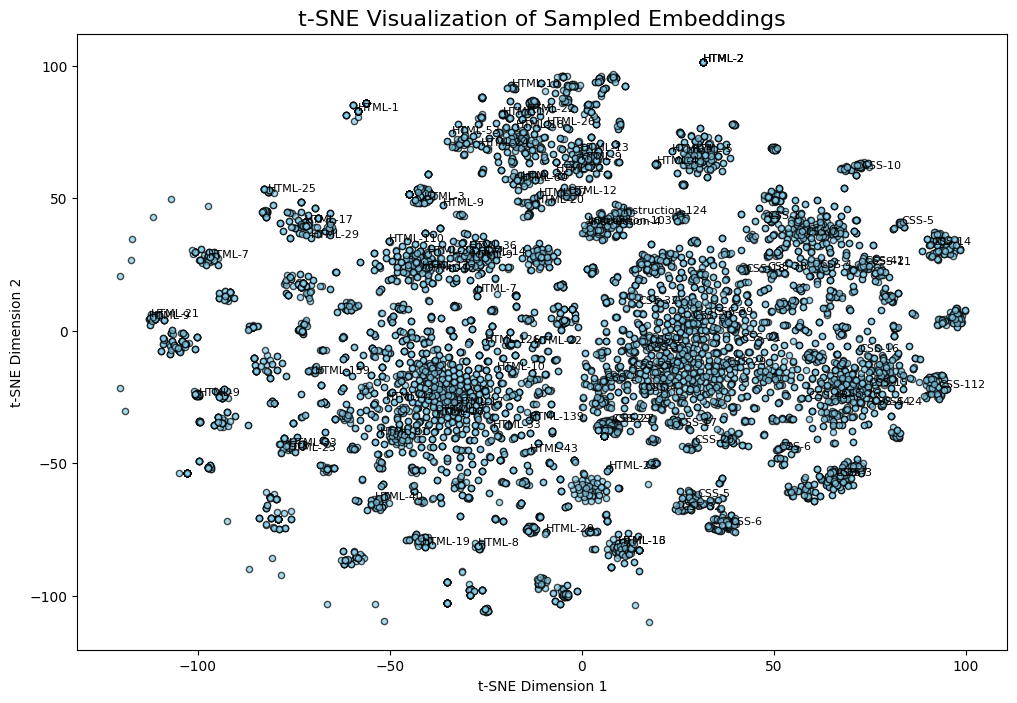

In [34]:
import pandas as pd
import numpy as np

# Load the data
file_path = "/Users/bhavikpatel/Desktop/RAG/RAG_Data/unified_data_with_embeddings.csv"
data = pd.read_csv(file_path)

# Ensure embeddings are properly formatted
data["Embedding"] = data["Embedding"].apply(eval)

# Sample a subset of the data (e.g., 10,000 rows)
sample_size = 10000
sample_data = data.sample(n=sample_size, random_state=42)

# Extract embeddings and IDs
embeddings = np.array(sample_data["Embedding"].to_list())
ids = sample_data["ID"].to_list()

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE for dimensionality reduction
print("Running t-SNE on sampled data...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plot the reduced embeddings
plt.figure(figsize=(12, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7, c="skyblue", edgecolors="k", s=20)
for i, txt in enumerate(ids[:100]):  # Annotate first 100 points only for readability
    plt.annotate(txt, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=8)
plt.title("t-SNE Visualization of Sampled Embeddings", fontsize=16)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


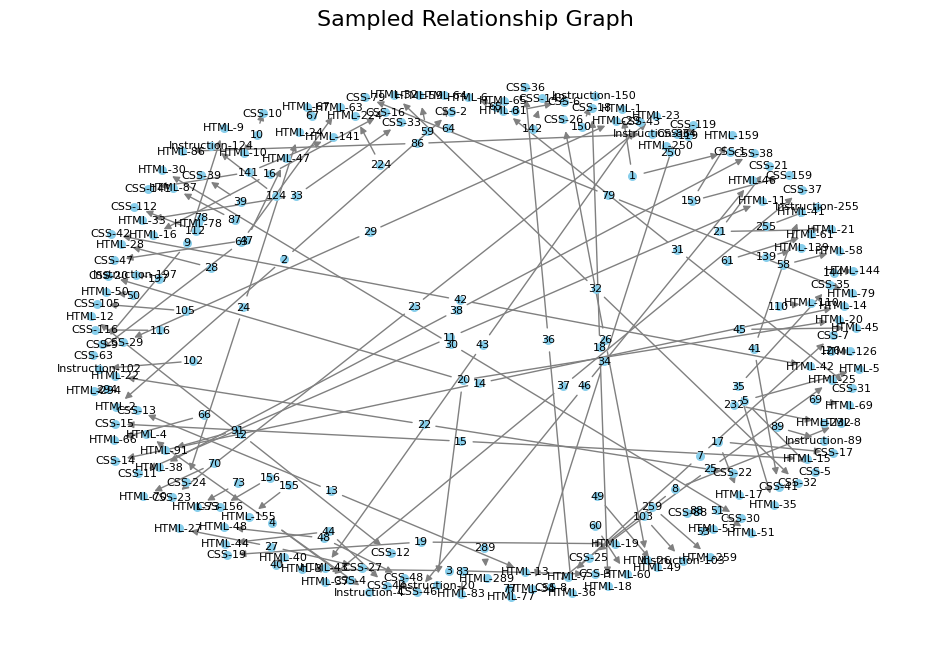

In [35]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a small sample of relationships
relationship_sample = sample_data[["ID", "Source_ID"]].head(500)  # Take 500 relationships
graph = nx.DiGraph()

# Add edges (relationships)
for _, row in relationship_sample.iterrows():
    graph.add_edge(row["Source_ID"], row["ID"])

# Draw the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(graph, seed=42)
nx.draw_networkx_nodes(graph, pos, node_size=30, node_color="skyblue")
nx.draw_networkx_edges(graph, pos, arrowstyle="-|>", arrowsize=10, edge_color="gray")
nx.draw_networkx_labels(graph, pos, font_size=8, font_color="black")
plt.title("Sampled Relationship Graph", fontsize=16)
plt.axis("off")
plt.show()


In [39]:
pip install umap-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 63.9 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


Running UMAP on sampled data...


/Users/bhavikpatel/tf_metal_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


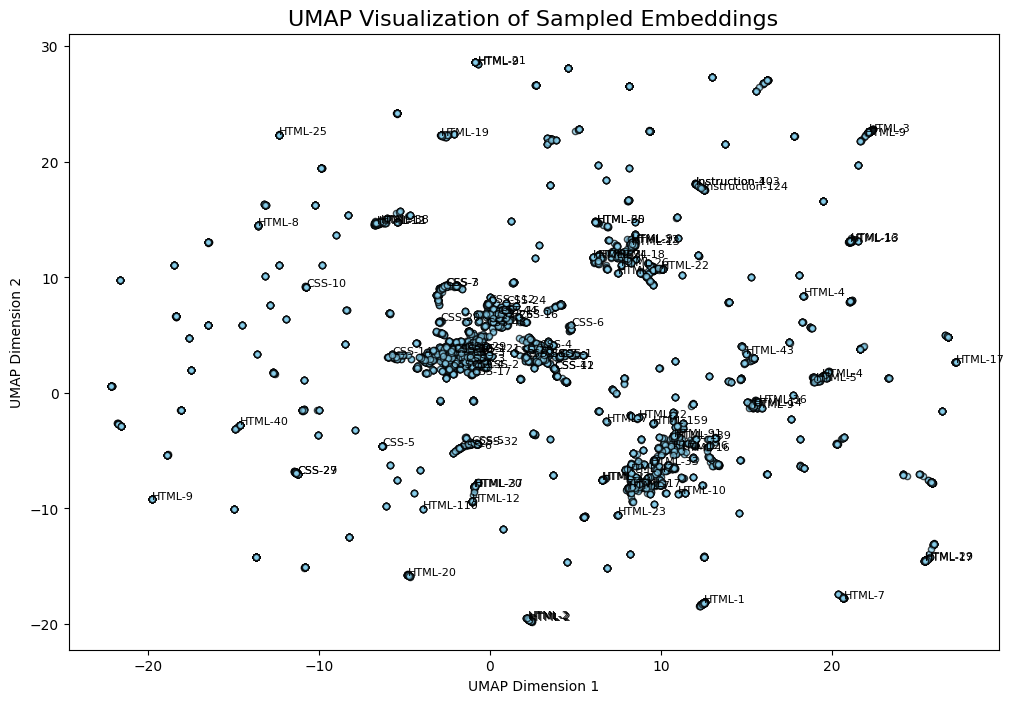

In [40]:
import pandas as pd
import numpy as np
import umap.umap_ as umap

import matplotlib.pyplot as plt

# Load the data
file_path = "/Users/bhavikpatel/Desktop/RAG/RAG_Data/unified_data_with_embeddings.csv"
data = pd.read_csv(file_path)

# Ensure embeddings are properly formatted
data["Embedding"] = data["Embedding"].apply(eval)

# Sample a subset of the data (e.g., 10,000 rows)
sample_size = 10000  # Adjust sample size based on your visualization needs
sample_data = data.sample(n=sample_size, random_state=42)

# Extract embeddings and IDs
embeddings = np.array(sample_data["Embedding"].to_list())
ids = sample_data["ID"].to_list()

# Apply UMAP for dimensionality reduction
print("Running UMAP on sampled data...")
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=42)
reduced_embeddings = umap_reducer.fit_transform(embeddings)

# Plot the UMAP results
plt.figure(figsize=(12, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7, c="skyblue", edgecolors="k", s=20)

# Annotate a subset of points for better readability
for i, txt in enumerate(ids[:100]):  # Annotate only the first 100 points
    plt.annotate(txt, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=8)

# Add plot labels and title
plt.title("UMAP Visualization of Sampled Embeddings", fontsize=16)
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()
